In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from scipy.stats import entropy
#from sklearn.linear_model import LogisticRegression
from polyagamma import random_polyagamma
from utils.generate import GenerateData_binomial
from utils.metrics import KLD
from models.proposed_method import proposed_method_binomial
from models.compared_methods import compared_methods

In [2]:
import warnings
warnings.filterwarnings('ignore')

# バイアスアルゴリズム： 非線形

In [17]:
Ex_num = 10 # パラメータを生成する回数

# 特徴量の数を設定
n_features = 1

# 特徴量の平均と標準偏差を設定
X_mu = [0]
X_sigma = [3]

# パラメータの平均と標準偏差を設定
beta_mu = [-2,4]
beta_sigma = [0.5,0.5]

threshfold_list = [-2, -1, 0, 1, 2]

KL_list = [] # 結果格納用 (threshfoldの数, 3)→ 標本平均, 比較手法，提案手法
P_list = [] # (threshfold, 2)

for threshfold in threshfold_list:

    KL_list_proposed_by_condition = []
    KL_list_sample_mean_by_condition = []
    KL_list_ML_by_condition = []
    P_list_population_by_condition = []
    P_list_sample_by_condition = []

    trial = 0
    with tqdm() as pbar:
        while trial < Ex_num: # パラメータによるモンテカルロ平均（ベイズ最適な推定量）
            # クラスをインスタンス化
            generator = GenerateData_binomial(
                n_features=n_features,
                X_mu_list=X_mu,
                X_sigma_list=X_sigma,
                beta_mu=beta_mu, # beta_mu_matrixをbeta_muに変更
                beta_sigma=beta_sigma # beta_sigma_matrixをbeta_sigmaに変更
            )

            # データを生成
            X, y = generator.generate_non_bias_data()
            X_bias, y_bias, _ = generator.generate_bias_data(n_samples=100, X_features_bias= 1 , threshfold= threshfold,sample_type="prop")

            if (y_bias.mean() != 1) & (y_bias.mean() != 0): # 0と1両方あるサンプルが生成できた場合のみ計算を実行する

                b_0 = np.array([0.001, 0.001])
                B_0 = np.array([np.diag([10, 10])]) # B_0の形状を変更

                burn = 5000
                draw = 10000

                # proposed_method_binomialのインスタンスを作成
                method = proposed_method_binomial(X_bias, y_bias, b_0, B_0, X_mu, X_sigma, burn, draw) # proposed_methodをproposed_method_binomialに変更
                compared_method = compared_methods(X_bias, y_bias, X_mu, X_sigma)

                # sample_betaメソッドを実行
                beta_posterior = method.sample_beta()

                P_true = y.mean()
                P_sample_mean = y_bias.mean()
                P_ML = compared_method.maximum_likelihood(draw=draw)
                P_proposed = method.estimate()

                KL_list_sample_mean_by_condition.append(KLD(P_true, P_sample_mean))
                KL_list_ML_by_condition.append(KLD(P_true, P_ML))
                KL_list_proposed_by_condition.append(KLD(P_true, P_proposed))

                P_list_population_by_condition.append(P_true)
                P_list_sample_by_condition.append(P_sample_mean)

                pbar.update(1)
                trial += 1
            #else:
            #    print("バイアスサンプルの生成に失敗しました")

    # 提案手法と比較手法の結果を表示
    print(f"実験条件:{threshfold=}")
    print("サンプル平均P:", np.mean(KL_list_sample_mean_by_condition))
    print("最尤推定P:", np.mean(KL_list_ML_by_condition))
    print("提案手法P:", np.mean(KL_list_proposed_by_condition))

    KL_list.append([np.mean(KL_list_sample_mean_by_condition), np.mean(KL_list_ML_by_condition), np.mean(KL_list_proposed_by_condition)])
    P_list.append([np.mean(P_list_population_by_condition), np.mean(P_list_sample_by_condition)])
KL_list

10it [00:24,  2.42s/it]


実験条件:threshfold=-2
サンプル平均P: 0.056763789180025184
最尤推定P: 0.002842003068343912
提案手法P: 0.00046124324642730084


10it [00:24,  2.40s/it]


実験条件:threshfold=-1
サンプル平均P: 0.07299084773553906
最尤推定P: 0.002274915498470598
提案手法P: 0.00039781785257321235


10it [00:24,  2.49s/it]


実験条件:threshfold=0
サンプル平均P: 0.10227052420366563
最尤推定P: 0.002666209608024772
提案手法P: 0.0005769173007119322


10it [00:23,  2.34s/it]


実験条件:threshfold=1
サンプル平均P: 0.1639498492590311
最尤推定P: 0.0032647978881578887
提案手法P: 0.0013222110527780218


10it [00:23,  2.32s/it]

実験条件:threshfold=2
サンプル平均P: 0.21832350017702637
最尤推定P: 0.0018647511521382777
提案手法P: 0.0004944419951892765


[[np.float64(0.056763789180025184),
  np.float64(0.002842003068343912),
  np.float64(0.00046124324642730084)],
 [np.float64(0.07299084773553906),
  np.float64(0.002274915498470598),
  np.float64(0.00039781785257321235)],
 [np.float64(0.10227052420366563),
  np.float64(0.002666209608024772),
  np.float64(0.0005769173007119322)],
 [np.float64(0.1639498492590311),
  np.float64(0.0032647978881578887),
  np.float64(0.0013222110527780218)],
 [np.float64(0.21832350017702637),
  np.float64(0.0018647511521382777),
  np.float64(0.0004944419951892765)]]

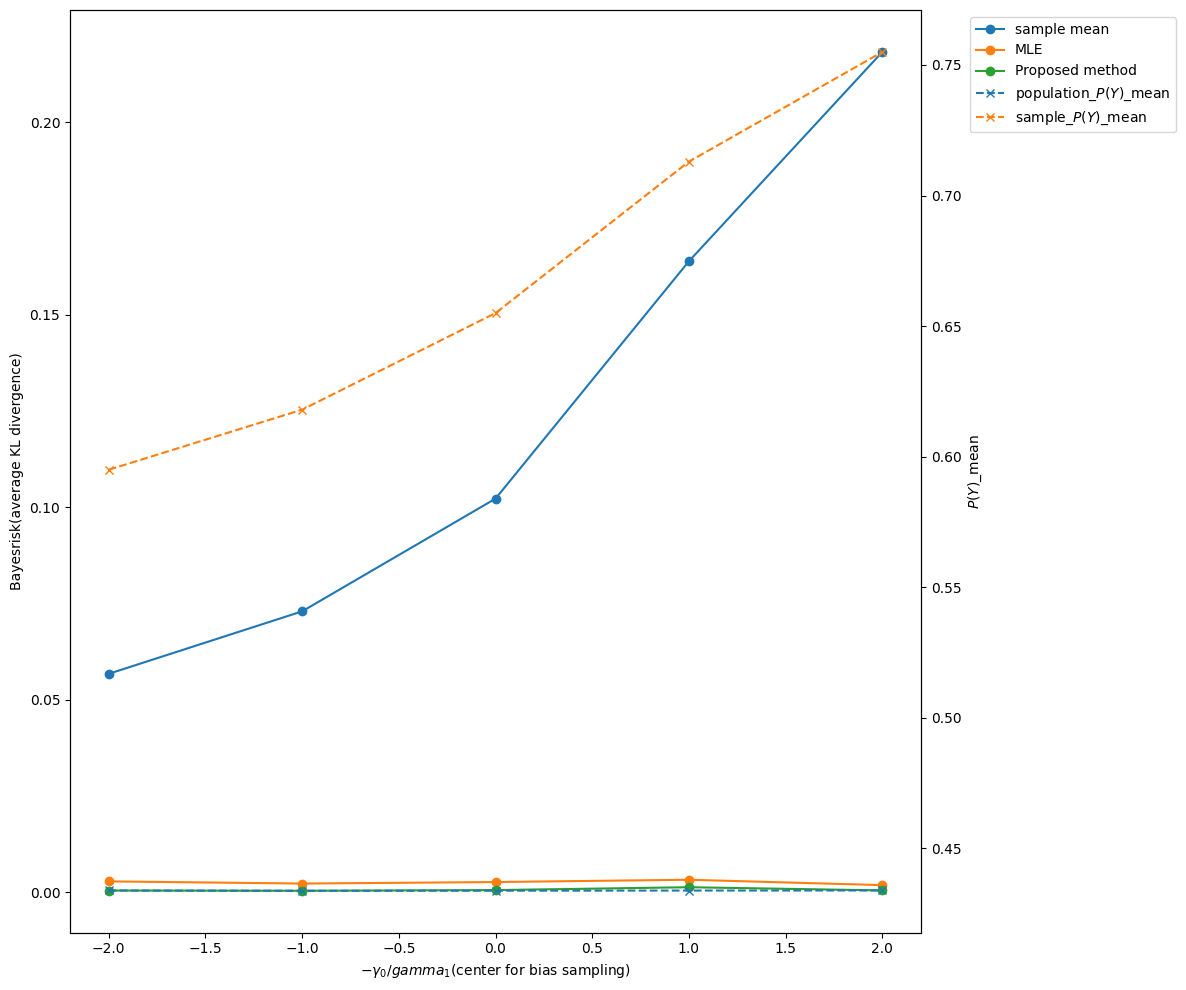

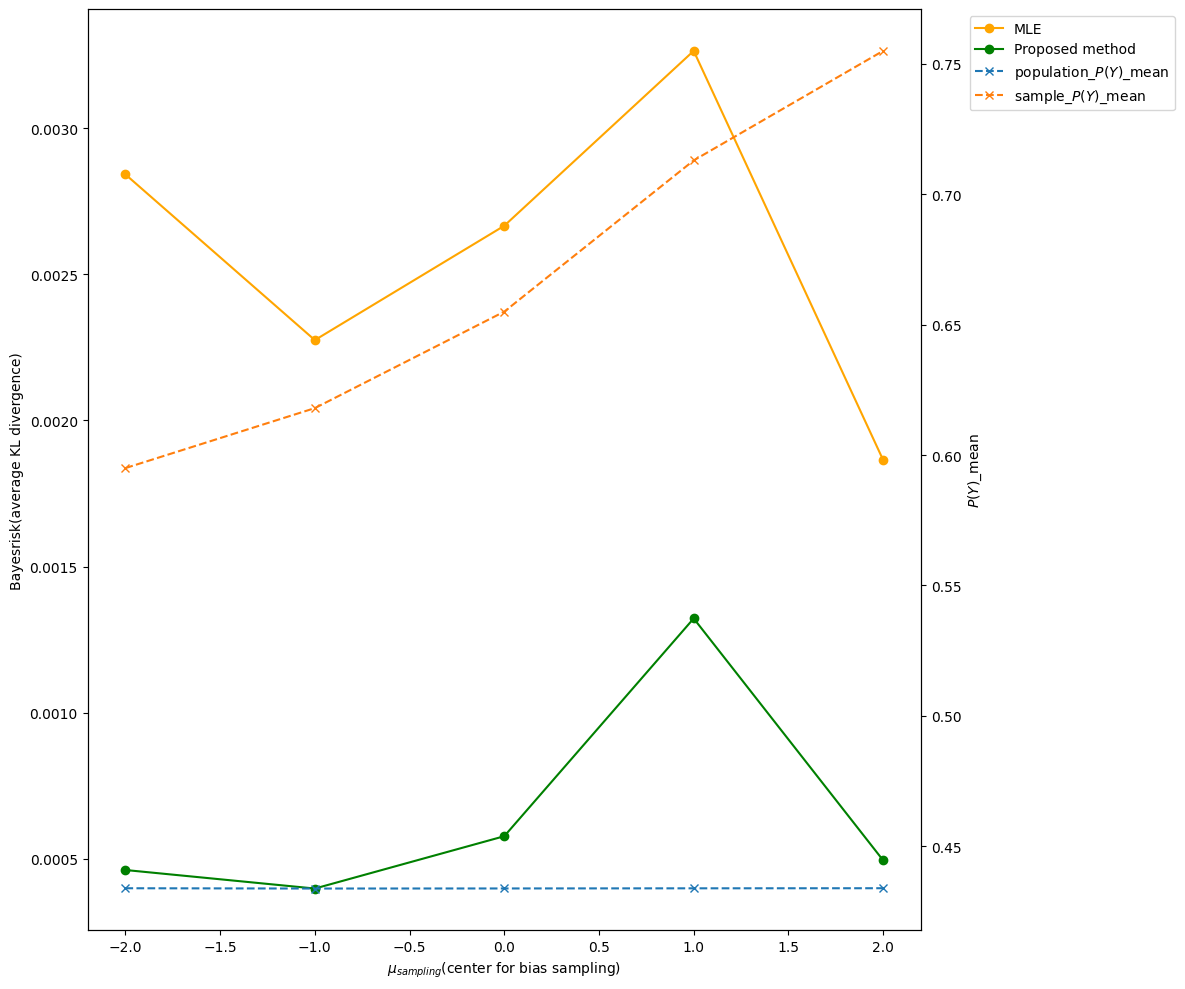

In [18]:
# データはすでに与えられていると仮定
KL_list = np.array(KL_list).T
P_list = np.array(P_list).T
label = ["sample mean", "MLE", "Proposed method"]

fig, ax1 = plt.subplots(1,1,figsize = (12,10))

# KL_listをプロット(ax1)
for i in range(3):
    ax1.plot(threshfold_list, KL_list[i], marker='o', linestyle='-', label=label[i])
ax1.set_xlabel("$-\gamma_0 / gamma_1$(center for bias sampling)")
ax1.set_ylabel("Bayesrisk(average KL divergence)")

# 2つ目のY軸を追加
ax2 = ax1.twinx()

# P_listを別の軸(ax2)でプロット
P_label = ["population_$P(Y)$_mean", "sample_$P(Y)$_mean"]
for i in range(2):
    ax2.plot(threshfold_list, P_list[i], marker='x', linestyle='--', label=P_label[i])

ax2.set_ylabel("$P(Y)$_mean")

# 凡例をまとめる
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# 凡例をグラフ領域外の右上に配置
ax1.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper left', 
           bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(1,1,figsize = (12,10))

# KL_listの1番目と2番目の系列のみ表示
for i in range(2):
    ax1.plot(threshfold_list, KL_list[i+1], marker='o', linestyle='-', label=label[i+1], color = 'orange' if i==0 else 'green')
ax1.set_xlabel("$\mu_{sampling}$(center for bias sampling)")
ax1.set_ylabel("Bayesrisk(average KL divergence)")

# 2つ目のY軸を追加
ax2 = ax1.twinx()

# P_listは従来通り全表示する場合（変更無し）
P_label = ["population_$P(Y)$_mean", "sample_$P(Y)$_mean"]
for i in range(2):
    ax2.plot(threshfold_list, P_list[i], marker='x', linestyle='--', label=P_label[i])

ax2.set_ylabel("$P(Y)$_mean")

# 凡例をまとめる
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# 凡例をグラフ領域外の右上に配置
ax1.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper left', 
           bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# バイアスアルゴリズム：peak

In [9]:
Ex_num = 10 # パラメータを生成する回数

# 特徴量の数を設定
n_features = 1

# 特徴量の平均と標準偏差を設定
X_mu = [0]
X_sigma = [3]

# パラメータの平均と標準偏差を設定
beta_mu = [-2,4]
beta_sigma = [0.5,0.5]

threshfold_list = [-2, -1, 0, 1, 2]

KL_list = [] # 結果格納用 (threshfoldの数, 3)→ 標本平均, 比較手法，提案手法
P_list = [] # (threshfold, 2)

for threshfold in threshfold_list:

    KL_list_proposed_by_condition = []
    KL_list_sample_mean_by_condition = []
    KL_list_ML_by_condition = []
    P_list_population_by_condition = []
    P_list_sample_by_condition = []

    trial = 0
    with tqdm() as pbar:
        while trial < Ex_num: # パラメータによるモンテカルロ平均（ベイズ最適な推定量）
            # クラスをインスタンス化
            generator = GenerateData_binomial(
                n_features=n_features,
                X_mu_list=X_mu,
                X_sigma_list=X_sigma,
                beta_mu=beta_mu, # beta_mu_matrixをbeta_muに変更
                beta_sigma=beta_sigma # beta_sigma_matrixをbeta_sigmaに変更
            )

            # データを生成
            X, y = generator.generate_non_bias_data()
            X_bias, y_bias, _ = generator.generate_bias_data(n_samples=100, X_features_bias= 1 , threshfold= threshfold, sample_type="norm")

            if (y_bias.mean() != 1) & (y_bias.mean() != 0): # 0と1両方あるサンプルが生成できた場合のみ計算を実行する

                b_0 = np.array([0.001, 0.001])
                B_0 = np.array([np.diag([10, 10])]) # B_0の形状を変更

                burn = 5000
                draw = 10000

                # proposed_method_binomialのインスタンスを作成
                method = proposed_method_binomial(X_bias, y_bias, b_0, B_0, X_mu, X_sigma, burn, draw) # proposed_methodをproposed_method_binomialに変更
                compared_method = compared_methods(X_bias, y_bias, X_mu, X_sigma)

                # sample_betaメソッドを実行
                beta_posterior = method.sample_beta()

                P_true = y.mean()
                P_sample_mean = y_bias.mean()
                P_ML = compared_method.maximum_likelihood(draw=draw)
                P_proposed = method.estimate()

                KL_list_sample_mean_by_condition.append(KLD(P_true, P_sample_mean))
                KL_list_ML_by_condition.append(KLD(P_true, P_ML))
                KL_list_proposed_by_condition.append(KLD(P_true, P_proposed))

                P_list_population_by_condition.append(P_true)
                P_list_sample_by_condition.append(P_sample_mean)

                pbar.update(1)
                trial += 1
            #else:
                #print("バイアスサンプルの生成に失敗しました")

    # 提案手法と比較手法の結果を表示
    print(f"実験条件:{threshfold=}")
    print("サンプル平均P:", np.mean(KL_list_sample_mean_by_condition))
    print("最尤推定P:", np.mean(KL_list_ML_by_condition))
    print("提案手法P:", np.mean(KL_list_proposed_by_condition))

    KL_list.append([np.mean(KL_list_sample_mean_by_condition), np.mean(KL_list_ML_by_condition), np.mean(KL_list_proposed_by_condition)])
    P_list.append([np.mean(P_list_population_by_condition), np.mean(P_list_sample_by_condition)])
KL_list

10it [00:24,  2.40s/it]


実験条件:threshfold=-2
サンプル平均P: 0.08221946296232541
最尤推定P: 0.0028040655530408133
提案手法P: 0.0006508418038999042


10it [00:22,  2.27s/it]


実験条件:threshfold=-1
サンプル平均P: 0.03842784178615638
最尤推定P: 0.002229476238067252
提案手法P: 0.0004878479731471264


10it [00:22,  2.29s/it]


実験条件:threshfold=0
サンプル平均P: 0.0061244679955962614
最尤推定P: 0.0025896309222133264
提案手法P: 0.00013016939978832687


10it [00:22,  2.28s/it]


実験条件:threshfold=1
サンプル平均P: 0.007120346180019765
最尤推定P: 0.001978735003286591
提案手法P: 0.00041464638939965327


10it [00:23,  2.30s/it]

実験条件:threshfold=2
サンプル平均P: 0.043792252949050946
最尤推定P: 0.002773579284134897
提案手法P: 0.0005888481850120031


[[np.float64(0.08221946296232541),
  np.float64(0.0028040655530408133),
  np.float64(0.0006508418038999042)],
 [np.float64(0.03842784178615638),
  np.float64(0.002229476238067252),
  np.float64(0.0004878479731471264)],
 [np.float64(0.0061244679955962614),
  np.float64(0.0025896309222133264),
  np.float64(0.00013016939978832687)],
 [np.float64(0.007120346180019765),
  np.float64(0.001978735003286591),
  np.float64(0.00041464638939965327)],
 [np.float64(0.043792252949050946),
  np.float64(0.002773579284134897),
  np.float64(0.0005888481850120031)]]

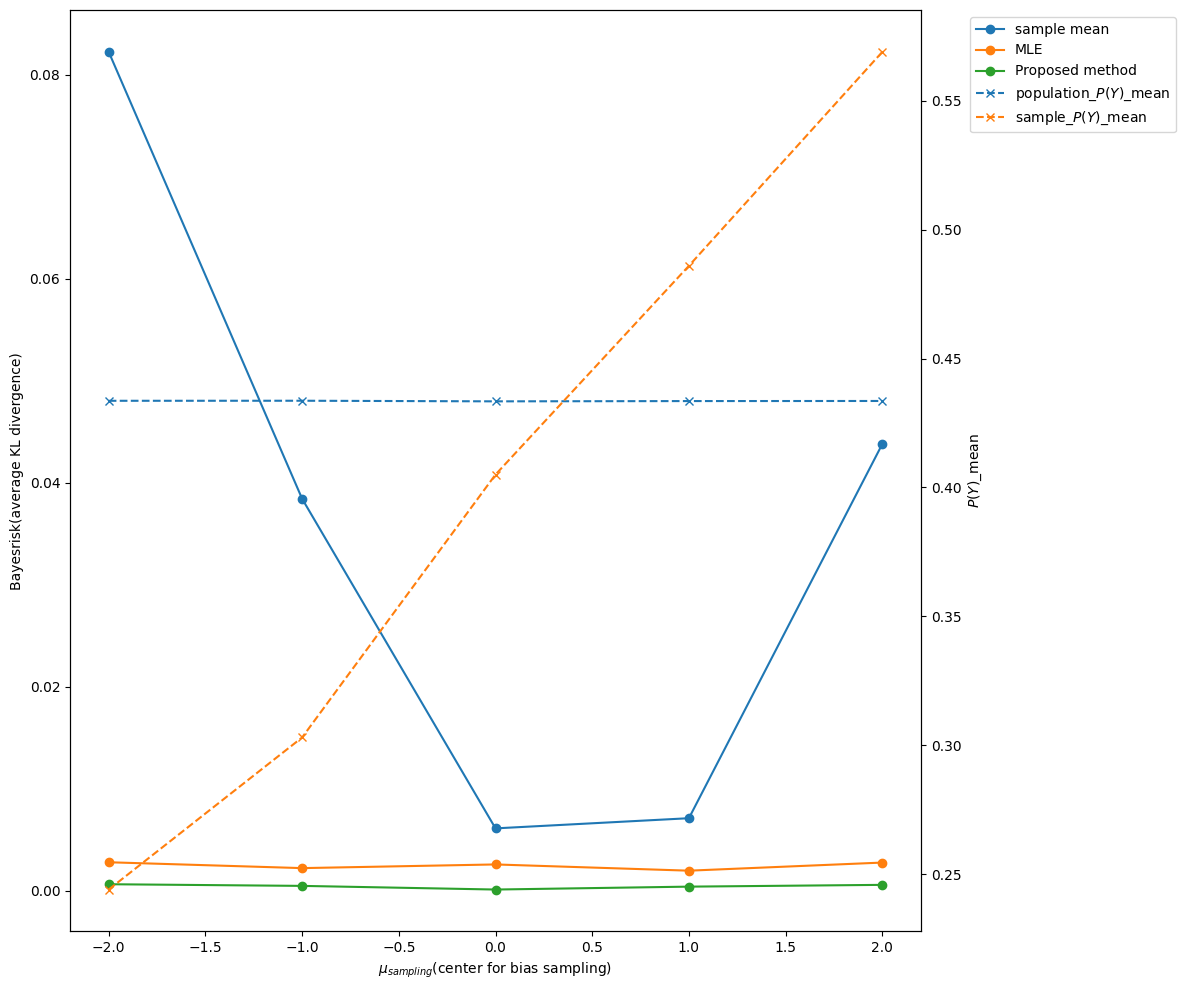

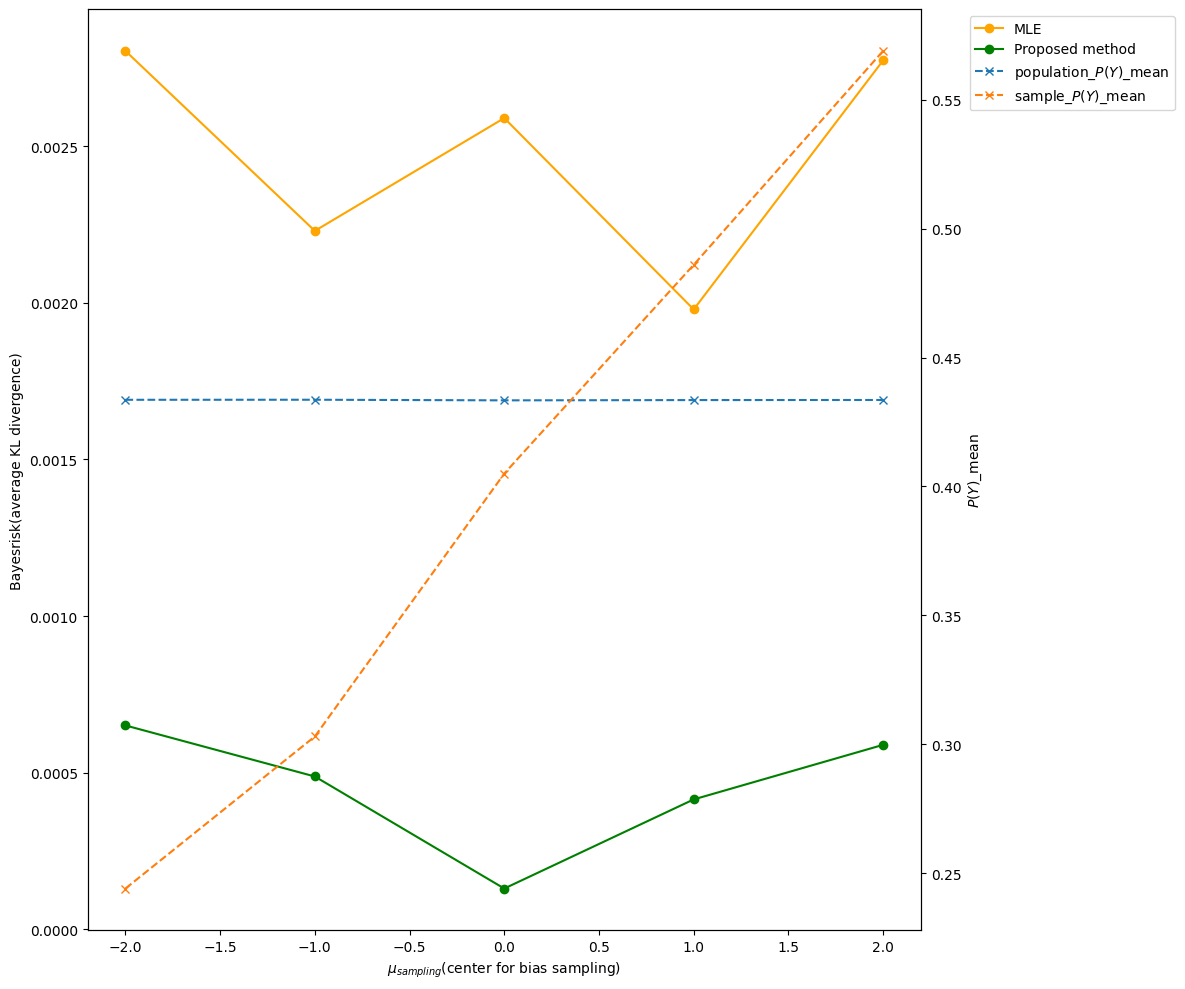

In [16]:
# データはすでに与えられていると仮定
KL_list = np.array(KL_list).T
P_list = np.array(P_list).T
label = ["sample mean", "MLE", "Proposed method"]

fig, ax1 = plt.subplots(1,1,figsize = (12,10))

# KL_listをプロット(ax1)
for i in range(3):
    ax1.plot(threshfold_list, KL_list[i], marker='o', linestyle='-', label=label[i])
ax1.set_xlabel("$\mu_{sampling}$(center for bias sampling)")
ax1.set_ylabel("Bayesrisk(average KL divergence)")

# 2つ目のY軸を追加
ax2 = ax1.twinx()

# P_listを別の軸(ax2)でプロット
P_label = ["population_$P(Y)$_mean", "sample_$P(Y)$_mean"]
for i in range(2):
    ax2.plot(threshfold_list, P_list[i], marker='x', linestyle='--', label=P_label[i])

ax2.set_ylabel("$P(Y)$_mean")

# 凡例をまとめる
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# 凡例をグラフ領域外の右上に配置
ax1.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper left', 
           bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(1,1,figsize = (12,10))

# KL_listの1番目と2番目の系列のみ表示
for i in range(2):
    ax1.plot(threshfold_list, KL_list[i+1], marker='o', linestyle='-', label=label[i+1], color = 'orange' if i==0 else 'green')
ax1.set_xlabel("$\mu_{sampling}$(center for bias sampling)")
ax1.set_ylabel("Bayesrisk(average KL divergence)")

# 2つ目のY軸を追加
ax2 = ax1.twinx()

# P_listは従来通り全表示する場合（変更無し）
P_label = ["population_$P(Y)$_mean", "sample_$P(Y)$_mean"]
for i in range(2):
    ax2.plot(threshfold_list, P_list[i], marker='x', linestyle='--', label=P_label[i])

ax2.set_ylabel("$P(Y)$_mean")

# 凡例をまとめる
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# 凡例をグラフ領域外の右上に配置
ax1.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper left', 
           bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()